## Reading JD

In [25]:
import PyPDF2

def job_description(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text


## Reading Resume

In [26]:
import PyPDF2

def applicant_resume(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

# text_applicant=applicant_resume("genairesume.pdf") 
# print(text_applicant)

In [59]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from langchain_groq import ChatGroq

class State(TypedDict):
    job_description: str
    applicant_resume: str
    summary: str
    job_fit_analysis: str
    score: str

## Creating Nodes

In [27]:
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from langchain_groq import ChatGroq

In [28]:
llm = ChatGroq(
    temperature=0,
    groq_api_key = "",
    model_name = "llama-3.3-70b-versatile"
)

In [35]:
applicant_resume_text = applicant_resume("genairesume.pdf")
job_description_text = job_description("sampleJD.pdf")

In [60]:
def summary_node(state: State) -> State:
    prompt = PromptTemplate(
        input_variables=["text"],
        template = "Summarize the following applicant's resume into a concise overview focusing on their key skills, work experience, and accomplishments relevant to [Job Role/Industry]. Keep it short and concise only 1 paragraph. {text}"
    )
    message = HumanMessage(content = prompt.format(text = state["applicant_resume"]))
    summary = llm.invoke([message]).content
    return {**state, "summary": summary}

# summary = summary_node(applicant_resume_text)
# print(summary)

In [61]:
def job_fit_node(state: State) -> State:
    prompt = PromptTemplate(
        input_variables=["job_description", "applicant_resume"],
        template = "You are a hiring expert. Based on the following job description and applicant's resume, determine if the applicant is a good fit for the job. \n\nJob Description: {job_description} \n\nApplicant Resume: {applicant_resume}"
    )
    message = HumanMessage(content = prompt.format(
        job_description = state["job_description"], 
        applicant_resume = state["applicant_resume"]
    ))
    analysis = llm.invoke([message]).content
    return {**state, "job_fit_analysis": analysis}

In [63]:
def score_node(state: State) -> State:
    prompt = PromptTemplate(
        input_variables=["job_description", "applicant_resume"],
        template = "You are a hiring expert. You are given a job description and an applicant's resume. You need to score the applicant's resume based on the job description. \n\nJob Description: {job_description} \n\nApplicant Resume: {applicant_resume}. Only give a score nothing else."
    )
    message = HumanMessage(content = prompt.format(
        job_description = state["job_description"], 
        applicant_resume = state["applicant_resume"]
    ))
    score = llm.invoke([message]).content
    return {**state, "score": score}

In [64]:
workflow = StateGraph(State)

workflow.add_node("summary_node", summary_node)
workflow.add_node("job_fit_node", job_fit_node)
workflow.add_node("score_node", score_node)

workflow.set_entry_point("summary_node")

workflow.add_edge("summary_node", "job_fit_node")
workflow.add_edge("job_fit_node", "score_node")
workflow.add_edge("score_node", END)

app = workflow.compile()

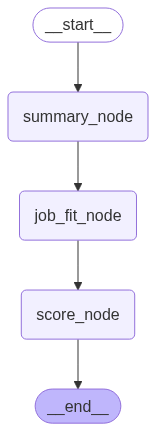

In [65]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [66]:
state_input = {
    "job_description": job_description_text,
    "applicant_resume": applicant_resume_text,
    "summary": "",
    "job_fit_analysis": "",
    "score": ""
}

result = app.invoke(state_input)
print("\nFinal State:")
print(f"Summary: {result['summary']}")
print(f"Job Fit Analysis: {result['job_fit_analysis']}")
print(f"Score: {result['score']}")


Final State:
Summary: Yunlong Jiao is a seasoned machine learning scientist with over 5 years of post-PhD experience, currently working at Amazon Alexa. He possesses strong skills in model development, performance evaluation, and proficiency in Python and deep learning frameworks. With a strong background in natural language processing, large language models, and deep generative models, Yunlong has led research on bias mitigation technologies and built/deployed ML solutions for Alexa Shopping. He has a proven track record of delivering projects, supervising research internships, and mentoring junior team members, making him a strong candidate for roles in AI research and development.
Job Fit Analysis: Based on the job description and the applicant's resume, I believe that Yunlong Jiao is a strong fit for the Artificial Intelligence Engineer position at Company X. Here's why:

1. **Relevant experience**: Yunlong has over 5 years of post-PhD experience in machine learning and AI, with a